# Introduction 

In [27]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss openpyxl pacmap

ERROR: Could not find a version that satisfies the requirement faiss (from versions: none)
ERROR: No matching distribution found for faiss


In [28]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)  # this will be helpful when visualizing retriever outputs

## Load your knowledge base

In [29]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [30]:
ds


Dataset({
    features: ['text', 'source'],
    num_rows: 2647
})

In [31]:
ds[0]

{'text': ' Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_region.png" alt="select region" />\n\n## 3. Defi

In [34]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)
]


  0%|          | 0/2647 [00:00<?, ?it/s]

In [36]:
RAW_KNOWLEDGE_BASE[:3]

[Document(page_content=' Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_region.png" alt="select region" />

## Splitting the documents into chunks

In [45]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    add_start_index=True, # Includes chunk start index in the metadata
    strip_whitespace=True, # Removes whitespace from beggining and end of the chunk
    separators=MARKDOWN_SEPARATORS
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

In [46]:
from sentence_transformers import SentenceTransformer

print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

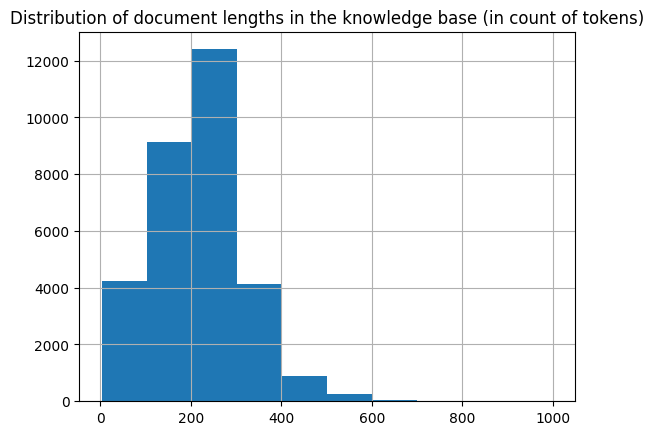

In [47]:
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [52]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"

def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter=RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,        
    )

    docs_processed = []
    for doc in tqdm(knowledge_base):
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in tqdm(docs_processed):
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

docs_processed = split_documents(
    512,
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME
)

  0%|          | 0/2647 [00:00<?, ?it/s]

  0%|          | 0/19983 [00:00<?, ?it/s]

  0%|          | 0/17995 [00:00<?, ?it/s]

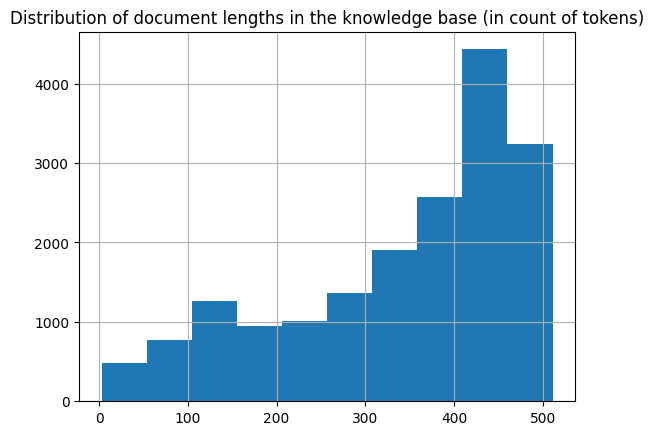

In [55]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)
